# Bernoulli Regression Multidimensional Model

**Sections**
- [0. Importing Modules](#0.-Importing-Modules)
- [1.0 Synthetic Data & Model](#1.0-Synthetic-Data-&-Model)
    - [1.1 Generating Synthetic Data](#1.1-Generating-Synthetic-Data)
- [2.0 NR Implementation](#2.0-Newton-Raphson-Implementation)
- [3.0 Variance of Estimators](#3.0-Variance-of-Estimators)
    - [3.1 Performing 5,000 experiments](#3.1-Performing-5,000-experiments)
    - [3.2 Plotting Distributions](#3.2-Plotting-Distributions)
    - [3.3 Variance of Estimator](#3.3-Variance-of-Estimator)
- [4.0 Hypothesis Testing](#4.0-Hypothesis-Testing)

### 0. Importing Modules

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import bokeh
from bokeh.plotting import figure, show
from bokeh.models import tickers, ranges
from bokeh.io import output_notebook
output_notebook()
from statistics import mean

Loading BokehJS ...

### 1.0 Synthetic Data & Model

- We generate 100 observations
- The model has 3 predictor variables, all generated independently from the standard normal density function.
- True parameters are $\beta_1 =2$, $\beta_2 =0$, $\beta_3 =-1$

\begin{align}
Givens \\ 
\large
b(\theta) & = log(1+e^\theta) \\
\large
p & = \dfrac{e^\theta}{1+e^\theta} \\
\theta & = log \dfrac{p}{1-p} \\
\\
\large
\mu & = b' (\theta) = \dfrac{e^\theta}{1+e^\theta} = p \\
\large
b'' (\theta) & = \dfrac{e^\theta}{(1+e^\theta)^2} = \mu(1-\mu)\\
\\
\large
\eta = x_i \cdot \beta  = g(\mu) & = log \dfrac{\mu}{1-\mu} = log \dfrac{p}{1-p} = \theta 
\end{align}

#### 1.1 Generating Synthetic Data

Predictor Variables 

In [2]:
n = 100
xArr = np.random.normal(loc=0.0, scale=1.0, size= (n,3)) 

True Parameters 

In [3]:
b = [2,-1,0]
pi = np.exp(xArr @ b) / (1 + np.exp(xArr @ b))
# y is supposed to be random, taking value either 0 or 1.
yi = np.random.binomial(1, pi) # One trial

W Matrix and Var

\begin{align}
\large
W &= (\dfrac{\partial \mu_i}{\partial \eta_i})^2 \dfrac{1}{b''(\theta)} \\
\large
\dfrac{\partial \eta_i}{\partial \mu_i} &= \dfrac{1}{\mu(1-\mu)} \therefore 
\dfrac{\partial \mu_i}{\partial \eta_i} = \mu(1-\mu) \\
\\
\large
W & = (\mu(1-\mu))^2 \dfrac{1}{\mu(1-\mu)} = \mu(1-\mu) = p(1-p) \\
\large
W_i & = \mu_i(1-\mu_i) = p_i(1-p_i) \\
\large
Var_i & = \dfrac{1}{W_i}
\end{align}

### 2.0 NR Implementation

In [4]:
def newton_n_iter(xArr, yi, b_0,  tolerance = 0.00001):
    """
    Performs Newton-Raphson root finding.
    
    Args:
        guess (float): initial value for parameter
        tolerance (float): tolerance
    
    """
    #Initialize
    b1 = [b_0[0]]
    b2 = [b_0[1]]
    b3 = [b_0[2]]
    
    difference = tolerance * 5
    iter_number = 0
   
    while abs(difference) > tolerance:
        
        
        pi = np.exp(xArr @ b_0) / (1 + np.exp(xArr @ b_0))
        Wi = np.diag(pi*(1-pi))
        z = xArr @ b_0 + (yi - pi) / (pi*(1-pi))
        beta_1 = np.linalg.inv(xArr.T @ Wi @ xArr) @ xArr.T @ Wi @ z

        b1.append(beta_1[0])
        b2.append(beta_1[1])
        b3.append(beta_1[2])
           
        # calculate difference and update iteration state
        difference = max(abs(np.array(beta_1) - np.array(b_0)))
        b_0 = beta_1
    
        iter_number += 1
    
    return beta_1, b1, b2, b3

In [20]:
beta_1, b1, b2, b3 = newton_n_iter(xArr, yi, [0, 0, 0])

In [6]:
p = figure(toolbar_location= None, outline_line_color = 'black')
p.line(x = range(len(b1)), y = b1, line_width = 1.5, line_color = 'blue',
    legend_label="Beta_1")
p.line(x = range(len(b2)), y = b2, line_width = 1.5, line_color = 'red',
    legend_label="Beta_2")
p.line(x = range(len(b3)), y = b3, line_width = 1.5, line_color = 'green',
    legend_label="Beta_3")

p.line(x= [0, len(b3)], y = b[0], line_color = 'blue', line_dash = 'dashed')
p.line(x= [0, len(b3)], y = b[1], line_color = 'red', line_dash = 'dashed')
p.line(x= [0, len(b3)], y = b[2], line_color = 'green', line_dash = 'dashed')
p.xaxis.axis_label = 'Iteration #'
p.yaxis.axis_label = 'Beta_1 | Beta_2 | Beta_3'
show(p)

### 3.0 Variance of Estimators

#### 3.1 Performing 5,000 experiments

With the same predictor variables, we peform 5000 experiments and hence obtain 5000 estimators. <br>
Use the non-parametric Bootstrap to find an approximate variance for $\hat\beta$.

In [55]:
#Empty Containers for estimators and variances
b1 = []
b2 = []
b3 = []
var_b1 = []
var_b2 = []
var_b3 = []
cov_b1b2 = []
cov_b1b3 = []
cov_b2b3 = []

# Bootstrapping
for _ in range(5000):    
    
    idx = np.random.choice(len(xArr), size=100, replace=True)
    x_arr = xArr[idx, :]
    y_arr = yi[idx]    
    beta_1, _, _, _ = newton_n_iter(x_arr, y_arr, [0, 0, 0])
    
    if np.isnan(beta_1).any():
        continue
    else:
        # If Newton Raphson converges add to lists
        b1.append(beta_1[0])
        b2.append(beta_1[1])
        b3.append(beta_1[2])
        
        # Calculating Variance of estimators
        pi = np.exp(x_arr @ beta_1) / (1 + np.exp(x_arr @ beta_1))
        Wi = np.diag(pi*(1-pi))        
        cov_matrix = np.linalg.inv(x_arr.T @ Wi @ x_arr)
        
        # Appending results
        var_b1.append(cov_matrix[0,0])
        var_b2.append(cov_matrix[1,1])
        var_b3.append(cov_matrix[2,2])
        cov_b1b2.append(cov_matrix[1,0])
        cov_b1b3.append(cov_matrix[2,0])
        cov_b2b3.append(cov_matrix[2,1])        

#### 3.2 Plotting Distributions

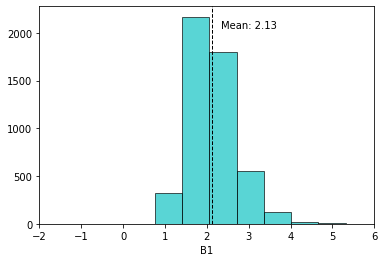

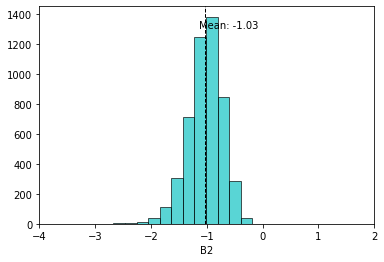

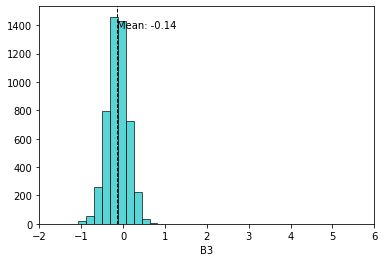

In [56]:
def plot_hist(x, name, left, right):
    if type(x).__name__ == 'list':
        x = np.array(x)
        
    plt.hist(x, bins=12, color='c', edgecolor='k', alpha=0.65)
    plt.axvline(x.mean(), color='k', linestyle='dashed', linewidth=1)
    min_ylim, max_ylim = plt.ylim()
    plt.text(x.mean()*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(x.mean()))
    plt.xlabel(name); plt.xlim(left,right); 
    plt.show()

plot_hist(b1, 'B1', -2, 6)
plot_hist(b2, 'B2', -4, 2)
plot_hist(b3, 'B3', -2, 6)

#### 3.3 Variance of Estimator

$Var (\hat\beta)$ Single Run

In [66]:
beta_1, _, _, _ = newton_n_iter(xArr, yi, [0, 0, 0])
beta_1

# Calculate terms based on beta-hat
pi = np.exp(xArr @ beta_1) / (1 + np.exp(xArr @ beta_1))
Wi = np.diag(pi*(1-pi))
z = xArr @ beta_1 + (yi - pi) / (pi*(1-pi))
beta_1 = np.linalg.inv(xArr.T @ Wi @ xArr) @ xArr.T @ Wi @ z

cov_beta_hat = np.linalg.inv(xArr.T @ Wi @ xArr)
cov_beta_hat

array([[ 0.19332076, -0.04853417,  0.01395896],
       [-0.04853417,  0.07490072,  0.01132414],
       [ 0.01395896,  0.01132414,  0.06991282]])

Average for the variances and covariances from 5000 experiments is

In [65]:
cov_beta_hat_ave = np.array([[mean(var_b1),mean(cov_b1b2),mean(cov_b1b3)],
                             [mean(cov_b1b2),mean(var_b2), mean(cov_b2b3)],
                             [mean(cov_b1b3),mean(cov_b2b3), mean(var_b3)]
                            ])
cov_beta_hat_ave

array([[ 0.24508063, -0.06321461,  0.01410148],
       [-0.06321461,  0.09068467,  0.01598882],
       [ 0.01410148,  0.01598882,  0.08059365]])

### 4.0 Hypothesis Testing

An experiment is carried out with n = 1000 and with
3 predictor variables with true values now given by: <br>
$\beta_1 =2$, $\beta_2 =1$, $\beta_3 =0$ <br>
The aim is to test the hypothesis: $H_o : \beta_3 = 0$

#### 1.1 Generating Synthetic Data

Predictor Variables 

In [2]:
n = 100
xArr = np.random.normal(loc=0.0, scale=1.0, size= (n,3)) 

True Parameters 

In [3]:
b = [2,-1,0]
pi = np.exp(xArr @ b) / (1 + np.exp(xArr @ b))
# y is supposed to be random, taking value either 0 or 1.
yi = np.random.binomial(1, pi) # One trial